In [14]:
!nvidia-smi

Tue Jul  8 10:12:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
# !pip install svgpathtools

In [16]:
# !pip install /kaggle/input/diffvg-cuda-enabled/diffvg/diffvg-0.0.1-cp311-cp311-linux_x86_64.whl

In [17]:
# !pip install cssutils

In [18]:
# !pip install -q opencv-python scikit-image pillow vtracer
# !pip install opencv-python-headless

In [19]:
# !apt-get update && apt-get install -y libopencv-dev

In [20]:
# !pip install svgpathtools
# !pip install cssutils
# !pip install google_re2
# !pip install svgwrite
# !pip install cairosvg bitsandbytes
# !pip install git+https://github.com/openai/CLIP.git
# !pip install -q opencv-python scikit-image pillow vtracer
# !pip install pynvml
# !pip install accelerate
# !pip install "jax[tpu]>=0.4.23" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
# !pip install flax ftfy
# !pip install scikit-build-core cmake ninja pybind11
# !pip install git+https://github.com/Opensource-Nice-Arishi/kaggle_drawing_with_LLMs.git@bitmap2svg-v0.2.5.1
# !pip install --upgrade nbdev fastcore fasttransform

In [21]:
#| default_exp core

In [22]:
#| export

import subprocess

subprocess.run(["pip", "install", f"/kaggle/input/diffvg-cuda-enabled/diffvg/diffvg-0.0.1-cp311-cp311-linux_x86_64.whl"])

Processing /kaggle/input/diffvg-cuda-enabled/diffvg/diffvg-0.0.1-cp311-cp311-linux_x86_64.whl


CompletedProcess(args=['pip', 'install', '/kaggle/input/diffvg-cuda-enabled/diffvg/diffvg-0.0.1-cp311-cp311-linux_x86_64.whl'], returncode=0)

In [23]:
# !pip install lpips

In [24]:
# img

In [25]:
# from IPython.display import SVG

# SVG(svg)

In [26]:
#| export

import kagglehub

import bitmap2svg

import os
import io
import re
import random
import base64
from io import BytesIO

import time
from datetime import timedelta

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from IPython.display import SVG

from PIL import Image
import cv2

from diffusers import StableDiffusionPipeline
from transformers import AutoProcessor, AutoModel

import logging
from lxml import etree

metric = kagglehub.package_import('nicecaliforniaw/forked-metric')

svg_constraints = kagglehub.package_import('metric/svg-constraints')

2025-07-08 10:12:54.380710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751969574.706608      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751969574.804004      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Installing python dependencies for Package 'kagglehub_package_nicecaliforniaw_forked_metric_4', logging progress to '/tmp/kagglehub-package-dependencies-install-ij4liua3.txt'.


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [27]:
# stable_diffusion_path = kagglehub.model_download("arishihu/stable-diffusion-v1-5/pytorch/default/2")

In [28]:
#| export

import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
from PIL import Image
import numpy as np
import re
import os
import random
import gc

import kagglehub

# 1. Import necessary libraries
import accelerate
import lpips # Import the LPIPS library

# Set memory allocation strategy
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Diffusers and Transformers
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer

# Differentiable SVG Renderer
import pydiffvg

import bitmap2svg

import logging

# Using SDv1.5 as it's often less resource-intensive than v2

# parse_svg_and_render function remains the same
def parse_svg_and_render(svg_string: str, width: int, height: int, device: str) -> torch.Tensor:
    polygons = re.findall(r'<polygon points="([^"]+)" fill="([^"]+)"/>', svg_string)
    shapes, shape_groups = [], []
    for points_str, fill_str in polygons:
        try:
            points_data = [float(p) for p in points_str.replace(',', ' ').split()]
            if not points_data or len(points_data) % 2 != 0: continue
            points = torch.tensor(points_data, dtype=torch.float32, device=device).view(-1, 2)
            hex_color = fill_str.lstrip('#')
            if len(hex_color) == 3: r, g, b = tuple(int(hex_color[i]*2, 16) for i in range(3))
            else: r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
            color = torch.tensor([r/255.0, g/255.0, b/255.0, 1.0], device=device)
            path = pydiffvg.Polygon(points=points, is_closed=True)
            shapes.append(path)
            shape_groups.append(pydiffvg.ShapeGroup(shape_ids=torch.tensor([len(shapes) - 1], device=device), fill_color=color))
        except (ValueError, IndexError): 
            continue
    
    bg_match = re.search(r'<rect .* fill="([^"]+)"/>', svg_string)
    bg_color_tensor = torch.tensor([0.0, 0.0, 0.0], device=device)
    if bg_match:
        hex_color = bg_match.group(1).lstrip('#')
        if len(hex_color) == 3: r, g, b = tuple(int(hex_color[i]*2, 16) for i in range(3))
        else: r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        bg_color_tensor = torch.tensor([r/255.0, g/255.0, b/255.0], device=device)
    
    if not shapes: 
        return bg_color_tensor.view(1, 3, 1, 1).expand(1, 3, height, width)
    
    scene_args = pydiffvg.RenderFunction.serialize_scene(width, height, shapes, shape_groups)
    render = pydiffvg.RenderFunction.apply
    img = render(width, height, 2, 2, 0, None, *scene_args)
    img = img[:, :, :3] * img[:, :, 3:4] + (1 - img[:, :, 3:4]) * bg_color_tensor
    img = img.unsqueeze(0).permute(0, 3, 1, 2)
    
    return img

def generate_svg_with_guidance(
    prompt: str,
    negative_prompt: str = "",
    model_id: str = "runwayml/stable-diffusion-v1-5",
    device: str = "cuda:0",
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    vector_guidance_scale: float = 1.5,
    # --- New Parameter for Hybrid Loss ---
    lpips_mse_lambda: float = 0.1, # Weight for balancing LPIPS and MSE
    guidance_start_step: int = 5,
    guidance_end_step: int = 40,
    guidance_resolution: int = 256,
    guidance_interval: int = 2,
    output_path: str = "output_guided_svg.svg",
    seed: int | None = None,
    # Your memory optimization flags are preserved
    enable_attention_slicing: bool = True,
    enable_cpu_offload: bool = True,
    use_half_precision: bool = True,
    batch_size: int = 1,  
    enable_sequential_cpu_offload: bool = True,
    low_vram_shift_to_cpu: bool = True
):

    if seed is None:
        seed = random.randint(0, 2**32 - 1)
    
    generator = torch.Generator(device=device).manual_seed(seed)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
    
    # torch.cuda.set_per_process_memory_fraction(0.95)

    # --- 2. Initialize LPIPS model on CPU to save VRAM ---
    print("Initializing LPIPS model on CPU...")
    loss_fn_lpips = lpips.LPIPS(net='vgg').to("cpu").eval()

    # The rest of your highly optimized model loading logic is preserved
    dtype = torch.float16 if use_half_precision else torch.float32
    loading_kwargs = {"torch_dtype": dtype, "use_safetensors": True, "low_cpu_mem_usage": True}
    if use_half_precision: loading_kwargs["variant"] = "fp16"
    
    try:
        vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae", **loading_kwargs)
        text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", **loading_kwargs)
        unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", **loading_kwargs)
    except Exception as e:
        vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae", torch_dtype=dtype)
        text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", torch_dtype=dtype)
        unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", torch_dtype=dtype)
    
    tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
    scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")

    # Preserving all your enable/disable logic for memory management
    if enable_attention_slicing:
        try:
            if hasattr(unet, 'enable_attention_slicing'): unet.enable_attention_slicing(1)
            elif hasattr(unet, 'set_attention_slice'): unet.set_attention_slice(1)
        except Exception as e: logging.error(f"Could not enable attention slicing: {e}")
    
    if enable_sequential_cpu_offload:
        try:
            text_encoder, unet, vae = text_encoder.to("cpu"), unet.to("cpu"), vae.to("cpu")
            unet = accelerate.cpu_offload(unet, execution_device=device)
            vae = accelerate.cpu_offload(vae, execution_device=device)
            text_encoder = accelerate.cpu_offload(text_encoder, execution_device=device)
        except Exception as e:
            text_encoder, unet, vae = text_encoder.to("cpu"), unet.to("cpu"), vae.to("cpu")
            enable_sequential_cpu_offload = False
            low_vram_shift_to_cpu = True
    else:
        text_encoder, unet, vae = text_encoder.to("cpu"), unet.to("cpu"), vae.to("cpu")

    try:
        if hasattr(unet, 'enable_xformers_memory_efficient_attention'):
            unet.enable_xformers_memory_efficient_attention()
    except (ImportError, AttributeError, Exception) as e:
        logging.error(f"Could not enable xFormers: {e}")
        
    try:
        if hasattr(unet, 'enable_gradient_checkpointing'):
            unet.enable_gradient_checkpointing()
    except Exception as e:
        logging.error(f"Could not enable gradient checkpointing: {e}")

    # --- Input Preparation (Preserved) ---
    gc.collect()
    torch.cuda.empty_cache()
    height = 512
    width = 512
    
    with torch.no_grad():
        if low_vram_shift_to_cpu and not enable_sequential_cpu_offload: text_encoder = text_encoder.to(device)
        text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
        if low_vram_shift_to_cpu and not enable_sequential_cpu_offload: text_encoder = text_encoder.to("cpu")
        
        uncond_input = tokenizer([negative_prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
        if low_vram_shift_to_cpu and not enable_sequential_cpu_offload: text_encoder = text_encoder.to(device)
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
        if low_vram_shift_to_cpu and not enable_sequential_cpu_offload: text_encoder = text_encoder.to("cpu")

    text_embeddings = torch.cat([uncond_embeddings, text_embeddings]).to(device=device, dtype=dtype)
    del uncond_embeddings
    gc.collect()
    torch.cuda.empty_cache()
    
    latent_height = int(height // 8)
    latent_width = int(width // 8)
    latents = torch.randn((batch_size, unet.config.in_channels, latent_height, latent_width), generator=generator, device=device, dtype=dtype)
    latents = latents * scheduler.init_noise_sigma
    
    scheduler.set_timesteps(num_inference_steps)
    
    svg_params_guidance = {
        'num_colors': None,
        'simplification_epsilon_factor': 0.02,
        'min_contour_area': (guidance_resolution/512)**2 * 30.0,
        'max_features_to_render': 64
    }

    # --- Denoising Loop with Perceptual Loss ---
    for i, t in enumerate(tqdm(scheduler.timesteps)):
        if i % 5 == 0: gc.collect(); torch.cuda.empty_cache()
        
        with torch.no_grad():
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)
            if low_vram_shift_to_cpu and not enable_sequential_cpu_offload: unet = unet.to(device)
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
            if low_vram_shift_to_cpu and not enable_sequential_cpu_offload: unet = unet.to("cpu")
        
        del latent_model_input
        gc.collect(); torch.cuda.empty_cache()
        
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred_cfg = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        if guidance_start_step <= i < guidance_end_step and i % guidance_interval == 0:
            with torch.no_grad():
                pred_original_sample = scheduler.step(noise_pred_cfg, t, latents).pred_original_sample
                
                if low_vram_shift_to_cpu and not enable_sequential_cpu_offload: vae = vae.to(device)
                decoded_image_tensor = vae.decode(1 / vae.config.scaling_factor * pred_original_sample).sample
                if low_vram_shift_to_cpu and not enable_sequential_cpu_offload: vae = vae.to("cpu")
                
                target_image_for_loss = decoded_image_tensor
                if guidance_resolution < height:
                    target_image_for_loss = F.interpolate(decoded_image_tensor.float(), size=(guidance_resolution, guidance_resolution), mode='bilinear', align_corners=False).to(dtype)

                img_to_vectorize_scaled = (target_image_for_loss / 2 + 0.5).clamp(0, 1)
                image_np = (img_to_vectorize_scaled.squeeze(0).permute(1, 2, 0).cpu().float().numpy() * 255).astype(np.uint8)
                pil_image = Image.fromarray(image_np)
                svg_string = bitmap2svg.bitmap_to_svg(pil_image, **svg_params_guidance)
                rendered_svg_tensor = parse_svg_and_render(svg_string, pil_image.width, pil_image.height, device)
                rendered_svg_tensor_scaled = rendered_svg_tensor * 2.0 - 1.0

                # --- 3. HYBRID LOSS CALCULATION with careful memory management ---
                # Move LPIPS model and tensors to GPU for calculation then immediately back
                loss_fn_lpips.to(device)
                
                # LPIPS expects images in range [-1, 1]
                loss_lpips_val = loss_fn_lpips(target_image_for_loss.float(), rendered_svg_tensor_scaled.float()).mean()
                
                loss_fn_lpips.to("cpu") # Immediately offload back to CPU
                
                loss_mse_val = F.mse_loss(target_image_for_loss, rendered_svg_tensor_scaled)
                loss = loss_lpips_val + lpips_mse_lambda * loss_mse_val

                grad = noise_pred_text - noise_pred_uncond
                noise_pred_cfg = noise_pred_cfg + (grad * loss.item() * vector_guidance_scale)

                del pred_original_sample, decoded_image_tensor, rendered_svg_tensor, rendered_svg_tensor_scaled, target_image_for_loss
                del img_to_vectorize_scaled, pil_image, svg_string
                
            gc.collect(); torch.cuda.empty_cache()
        
        latents = scheduler.step(noise_pred_cfg, t, latents).prev_sample
        
    # --- Final Generation (Preserved) ---
    with torch.no_grad():
        if low_vram_shift_to_cpu and not enable_sequential_cpu_offload: vae = vae.to(device)
        latents = 1 / vae.config.scaling_factor * latents
        image_tensor = vae.decode(latents).sample
        if low_vram_shift_to_cpu and not enable_sequential_cpu_offload: vae = vae.to("cpu")
    
    image_tensor = (image_tensor.to("cpu") / 2 + 0.5).clamp(0, 1)
    image_np = (image_tensor.squeeze(0).permute(1, 2, 0).float().numpy() * 255).astype(np.uint8)
    final_image = Image.fromarray(image_np)
    
    final_svg_params = {
        'num_colors': None,
        'simplification_epsilon_factor': 0.002,
        'min_contour_area': 0.5,
        'max_features_to_render': 0
    }
    final_svg_string = bitmap2svg.bitmap_to_svg(final_image, **final_svg_params)

    return final_image, final_svg_string

In [29]:
# #| export

# import torch
# import torch.nn.functional as F
# from tqdm.auto import tqdm
# from PIL import Image
# import numpy as np
# import re
# import os
# import random
# import gc

# import kagglehub

# # 1. Import accelerate
# import accelerate

# # Set memory allocation strategy
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# # Diffusers and Transformers
# from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
# from transformers import CLIPTextModel, CLIPTokenizer

# # Differentiable SVG Renderer
# import pydiffvg

# import bitmap2svg

# import logging

# # stable_diffusion_path = kagglehub.model_download("stabilityai/stable-diffusion-v2/pytorch/1/1")
# stable_diffusion_path = kagglehub.model_download("arishihu/stable-diffusion-v1-5/pytorch/default/2")

# def parse_svg_and_render(svg_string: str, width: int, height: int, device: str) -> torch.Tensor:
#     polygons = re.findall(r'<polygon points="([^"]+)" fill="([^"]+)"/>', svg_string)
#     shapes, shape_groups = [], []
#     for points_str, fill_str in polygons:
#         try:
#             points_data = [float(p) for p in points_str.replace(',', ' ').split()]
#             if not points_data or len(points_data) % 2 != 0: continue
#             points = torch.tensor(points_data, dtype=torch.float32, device=device).view(-1, 2)
#             hex_color = fill_str.lstrip('#')
#             if len(hex_color) == 3: r, g, b = tuple(int(hex_color[i]*2, 16) for i in range(3))
#             else: r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
#             color = torch.tensor([r/255.0, g/255.0, b/255.0, 1.0], device=device)
#             path = pydiffvg.Polygon(points=points, is_closed=True)
#             shapes.append(path)
#             shape_groups.append(pydiffvg.ShapeGroup(shape_ids=torch.tensor([len(shapes) - 1], device=device), fill_color=color))
#         except (ValueError, IndexError): 
#             continue
    
#     bg_match = re.search(r'<rect .* fill="([^"]+)"/>', svg_string)
#     bg_color_tensor = torch.tensor([0.0, 0.0, 0.0], device=device)
#     if bg_match:
#         hex_color = bg_match.group(1).lstrip('#')
#         if len(hex_color) == 3: r, g, b = tuple(int(hex_color[i]*2, 16) for i in range(3))
#         else: r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
#         bg_color_tensor = torch.tensor([r/255.0, g/255.0, b/255.0], device=device)
    
#     if not shapes: 
#         return bg_color_tensor.view(1, 3, 1, 1).expand(1, 3, height, width)
    
#     scene_args = pydiffvg.RenderFunction.serialize_scene(width, height, shapes, shape_groups)
#     render = pydiffvg.RenderFunction.apply
#     img = render(width, height, 2, 2, 0, None, *scene_args)
#     img = img[:, :, :3] * img[:, :, 3:4] + (1 - img[:, :, 3:4]) * bg_color_tensor
#     img = img.unsqueeze(0).permute(0, 3, 1, 2)
    
#     return img

# def generate_svg_with_guidance(
#     prompt: str,
#     negative_prompt: str = "",
#     model_id: str = "runwayml/stable-diffusion-v1-5",
#     device: str = "cuda:0",
#     num_inference_steps: int = 50,
#     guidance_scale: float = 7.5,
#     vector_guidance_scale: float = 1.5,
#     guidance_start_step: int = 5,
#     guidance_end_step: int = 40,
#     guidance_resolution: int = 256,
#     guidance_interval: int = 2,
#     output_path: str = "output_guided_svg.svg",
#     seed: int | None = None,
#     enable_attention_slicing: bool = True,
#     enable_cpu_offload: bool = True,
#     use_half_precision: bool = True,
#     batch_size: int = 1,  
#     enable_sequential_cpu_offload: bool = True,
#     low_vram_shift_to_cpu: bool = True
# ):
    
#     # model_id = stable_diffusion_path

#     if seed is None:
#         seed = random.randint(0, 2**32 - 1)
    
#     generator = torch.Generator(device=device).manual_seed(seed)
#     # print(f"Using seed: {seed}. Main device: {device}.")

#     gc.collect()
#     torch.cuda.empty_cache()
    
#     torch.backends.cuda.matmul.allow_tf32 = True
#     torch.backends.cudnn.allow_tf32 = True
#     torch.backends.cudnn.benchmark = True
    
#     torch.cuda.set_per_process_memory_fraction(0.95)  

#     # --- Load Models with Optimized Memory Management ---
#     # print("Loading models with optimized memory management...")
#     dtype = torch.float16 if use_half_precision else torch.float32
    
#     loading_kwargs = {
#         "torch_dtype": dtype,
#         "use_safetensors": True,
#         "low_cpu_mem_usage": True,  
#     }
    
#     if use_half_precision:
#         loading_kwargs["variant"] = "fp16"
    
#     try:
#         vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae", **loading_kwargs)
#         text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", **loading_kwargs)
#         unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", **loading_kwargs)
#     except Exception as e:
#         # print(f"Failed to load with optimized settings, falling back to default: {e}")
#         vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae", torch_dtype=dtype)
#         text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", torch_dtype=dtype)
#         unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", torch_dtype=dtype)
    
#     tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
#     scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")

#     if enable_attention_slicing:
#         try:
#             if hasattr(unet, 'enable_attention_slicing'):
#                 unet.enable_attention_slicing(1)  
#                 # print("Attention slicing enabled for UNet.")
#             elif hasattr(unet, 'set_attention_slice'):
#                 unet.set_attention_slice(1)
#                 # print("Attention slice set for UNet.")
#             # else:
#             #     print("Attention slicing not available for this UNet version.")
#         except Exception as e:
#             # print(f"Could not enable attention slicing: {e}")
#             logging.error(f"Could not enable attention slicing: {e}")
    
#     if enable_sequential_cpu_offload:
#         # print("Enabling sequential CPU offload for all models...")
        
#         try:
#             text_encoder = text_encoder.to("cpu")
#             unet = unet.to("cpu") 
#             vae = vae.to("cpu")
            
#             unet = accelerate.cpu_offload(unet, execution_device=device)
#             vae = accelerate.cpu_offload(vae, execution_device=device)
#             text_encoder = accelerate.cpu_offload(text_encoder, execution_device=device)
            
#             # print("Sequential CPU offload enabled successfully.")
#         except Exception as e:
#             # print(f"CPU offload failed, using manual device management: {e}")
#             text_encoder = text_encoder.to("cpu")
#             unet = unet.to("cpu")
#             vae = vae.to("cpu")
#             enable_sequential_cpu_offload = False
#             low_vram_shift_to_cpu = True
#     else:
#         # print("Using manual device management...")
#         text_encoder = text_encoder.to("cpu")
#         unet = unet.to("cpu")
#         vae = vae.to("cpu")

#     try:
#         if hasattr(unet, 'enable_xformers_memory_efficient_attention'):
#             unet.enable_xformers_memory_efficient_attention()
#             # print("xFormers enabled for UNet.")
#         # else:
#             # print("xFormers not available for this UNet version.")
#     except (ImportError, AttributeError, Exception) as e:
#         # print(f"Could not enable xFormers: {e}")
#         logging.error(f"Could not enable xFormers: {e}")
        
#     try:
#         if hasattr(unet, 'enable_gradient_checkpointing'):
#             unet.enable_gradient_checkpointing()
#             # print("Gradient checkpointing enabled for UNet.")
#     except Exception as e:
#         # print(f"Could not enable gradient checkpointing: {e}")
#         logging.error(f"Could not enable gradient checkpointing: {e}")

#     gc.collect()
#     torch.cuda.empty_cache()

#     # print("Preparing inputs with memory optimization...")
#     height = 512
#     width = 512
    
#     with torch.no_grad():
#         if low_vram_shift_to_cpu and not enable_sequential_cpu_offload:
#             text_encoder = text_encoder.to(device)
            
#         text_input = tokenizer(
#             [prompt], 
#             padding="max_length", 
#             max_length=tokenizer.model_max_length, 
#             truncation=True, 
#             return_tensors="pt"
#         )
        
#         text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
        
#         if low_vram_shift_to_cpu and not enable_sequential_cpu_offload:
#             text_encoder = text_encoder.to("cpu")
        
#         uncond_input = tokenizer(
#             [negative_prompt], 
#             padding="max_length", 
#             max_length=tokenizer.model_max_length, 
#             return_tensors="pt"
#         )
        
#         if low_vram_shift_to_cpu and not enable_sequential_cpu_offload:
#             text_encoder = text_encoder.to(device)
            
#         uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
        
#         if low_vram_shift_to_cpu and not enable_sequential_cpu_offload:
#             text_encoder = text_encoder.to("cpu")
    
#     gc.collect()
#     torch.cuda.empty_cache()

#     text_embeddings = torch.cat([uncond_embeddings, text_embeddings]).to(device=device, dtype=dtype)
    
#     del uncond_embeddings
#     gc.collect()
#     torch.cuda.empty_cache()
    
#     latent_height = int(height // 8)  # VAE scaling factor is 8
#     latent_width = int(width // 8)
#     latents = torch.randn(
#         (batch_size, unet.config.in_channels, latent_height, latent_width),
#         generator=generator, device=device, dtype=dtype
#     )
#     latents = latents * scheduler.init_noise_sigma
    
#     # print("Starting denoising and guidance loop...")
#     scheduler.set_timesteps(num_inference_steps)
    
#     svg_params_guidance = {
#         'num_colors': None,  
#         'simplification_epsilon_factor': 0.02,  
#         'min_contour_area': (guidance_resolution/512)**2 * 30.0,  
#         'max_features_to_render': 64  
#     }

#     for i, t in enumerate(tqdm(scheduler.timesteps)):
#         if i % 5 == 0:  
#             gc.collect()
#             torch.cuda.empty_cache()
        
#         with torch.no_grad():
#             latent_model_input = torch.cat([latents] * 2)
#             latent_model_input = scheduler.scale_model_input(latent_model_input, t)
            
#             if low_vram_shift_to_cpu and not enable_sequential_cpu_offload:
#                 unet = unet.to(device)
            
#             noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
            
#             if low_vram_shift_to_cpu and not enable_sequential_cpu_offload:
#                 unet = unet.to("cpu")
        
#         del latent_model_input
#         gc.collect()
#         torch.cuda.empty_cache()
        
#         noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
#         noise_pred_cfg = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
#         if guidance_start_step <= i < guidance_end_step and i % guidance_interval == 0:
#             with torch.no_grad():
#                 pred_original_sample = scheduler.step(noise_pred_cfg, t, latents).pred_original_sample
                
#                 if low_vram_shift_to_cpu and not enable_sequential_cpu_offload:
#                     vae = vae.to(device)
                
#                 decoded_image_tensor = vae.decode(1 / vae.config.scaling_factor * pred_original_sample).sample
                
#                 if low_vram_shift_to_cpu and not enable_sequential_cpu_offload:
#                     vae = vae.to("cpu")
                
#                 if guidance_resolution < height:
#                     decoded_image_tensor = F.interpolate(
#                         decoded_image_tensor.float(),
#                         size=(guidance_resolution, guidance_resolution),
#                         mode='bilinear',  
#                         align_corners=False
#                     ).to(dtype)

#                 img_to_vectorize_scaled = (decoded_image_tensor / 2 + 0.5).clamp(0, 1)
                
#                 image_np = (img_to_vectorize_scaled.squeeze(0).permute(1, 2, 0).cpu().float().numpy() * 255).astype(np.uint8)
#                 pil_image = Image.fromarray(image_np)
                
#                 svg_string = bitmap2svg.bitmap_to_svg(pil_image, **svg_params_guidance)
                
#                 rendered_svg_tensor = parse_svg_and_render(svg_string, pil_image.width, pil_image.height, device)
#                 rendered_svg_tensor_scaled = rendered_svg_tensor * 2.0 - 1.0

#                 decoded_image_tensor = decoded_image_tensor.to(device)
#                 loss = F.mse_loss(decoded_image_tensor, rendered_svg_tensor_scaled)
                
#                 grad = noise_pred_text - noise_pred_uncond
#                 noise_pred_cfg = noise_pred_cfg + (grad * loss.item() * vector_guidance_scale)

#                 del pred_original_sample, decoded_image_tensor, rendered_svg_tensor, rendered_svg_tensor_scaled
#                 del img_to_vectorize_scaled, pil_image, svg_string
                
#             gc.collect()
#             torch.cuda.empty_cache()
        
#         latents = scheduler.step(noise_pred_cfg, t, latents).prev_sample
        
#         if i % 10 == 0:
#             gc.collect()
#             torch.cuda.empty_cache()

#     # print("Generating final image and SVG...")
#     with torch.no_grad():
#         if low_vram_shift_to_cpu and not enable_sequential_cpu_offload:
#             vae = vae.to(device)
        
#         latents = 1 / vae.config.scaling_factor * latents
#         image_tensor = vae.decode(latents).sample
        
#         if low_vram_shift_to_cpu and not enable_sequential_cpu_offload:
#             vae = vae.to("cpu")
    
#     gc.collect()
#     torch.cuda.empty_cache()
    
#     image_tensor = (image_tensor.to("cpu") / 2 + 0.5).clamp(0, 1)
#     image_np = (image_tensor.squeeze(0).permute(1, 2, 0).float().numpy() * 255).astype(np.uint8)
#     final_image = Image.fromarray(image_np)
    
#     # raster_output_path = os.path.splitext(output_path)[0] + ".png"
#     # final_image.save(raster_output_path)
#     # print(f"Saved final raster image to: {raster_output_path}")

#     final_svg_params = {
#         'num_colors': None,  # Increase from 10 to 24 to capture more color nuance and texture
#         'simplification_epsilon_factor': 0.002, # Decrease from 0.008 to preserve fine details in shapes
#         'min_contour_area': 1.0,   # Decrease from 8.0 to keep smaller, important details
#         'max_features_to_render': 0 # Unlimited
#     }
#     final_svg_string = bitmap2svg.bitmap_to_svg(final_image, **final_svg_params)
    
#     # with open(output_path, "w") as f:
#     #     f.write(final_svg_string)
#     # print(f"Saved final SVG to: {output_path}")

#     return final_image, final_svg_string

## Competition Metric Helpers

See [metric package](https://www.kaggle.com/code/nicecaliforniaw/forked-metric).

In [30]:
import numpy as np
import statistics
import pandas as pd
import torch

def image_resize(image, size=(384, 384)):
    return image.convert('RGB').resize(size)

def bitmap_score_instance_impl(multiple_choice_qa, image, random_seed=42):
    rng = np.random.RandomState(random_seed)
    group_seed = rng.randint(0, np.iinfo(np.int32).max)
    image_processor = metric.ImageProcessor(image=image_resize(image), seed=group_seed).apply()
    image = image_processor.image.copy()
    questions = multiple_choice_qa['question']
    choices = multiple_choice_qa['choices']
    answers = multiple_choice_qa['answer']
    aesthetic_score = metric.aesthetic_evaluator.score(image)
    vqa_score = metric.vqa_evaluator.score(questions, choices, answers, image)
    image_processor.reset().apply_random_crop_resize().apply_jpeg_compression(quality=90)
    ocr_score = metric.vqa_evaluator.ocr(image_processor.image)
    instance_score = metric.harmonic_mean(vqa_score, aesthetic_score, beta=0.5) * ocr_score
    return instance_score, vqa_score, ocr_score, aesthetic_score

def bitmap_score_instance(multiple_choice_qa, image, random_seed=42):
    torch.cuda.empty_cache()
    is_single = not isinstance(image, list)
    if is_single:
        multiple_choice_qa = [multiple_choice_qa]
        image = [image]
    
    assert len(multiple_choice_qa) == len(image)

    results = []
    score_df = []
    for one_image, one_multiple_choice_qa in zip(image, multiple_choice_qa, strict=True):
        instance_score, vqa_score, ocr_score, aesthetic_score = bitmap_score_instance_impl(one_multiple_choice_qa, one_image, random_seed=42)
        results.append(instance_score)
        score_df.append([instance_score, vqa_score, ocr_score, aesthetic_score])

    fidelity = statistics.mean(results)
    score_df = pd.DataFrame(score_df, columns=['competition_score', 'vqa_score', 'ocr_score', 'aesthetic_score'])
    if is_single:
        return score_df.iloc[0].to_dict()
    else:
        return float(fidelity), score_df

## Add OCR Decoy to SVG

In [31]:
#| export

import random
import re
from colorsys import rgb_to_hls, hls_to_rgb

def add_ocr_decoy_svg(svg_code: str) -> str:
    """
    Adds nested circles with second darkest and second brightest colors from the existing SVG,
    positioned in one of the four corners (randomly selected) but positioned to avoid being
    cropped out during image processing.
    
    Parameters:
    -----------
    svg_code : str
        The original SVG string
    
    Returns:
    --------
    str
        Modified SVG with the nested circles added
    """
    modified_svg = svg_code
    try:
        # Check if SVG has a closing tag
        if "</svg>" not in svg_code:
            return svg_code
        
        # Extract viewBox if it exists to understand the dimensions
        viewbox_match = re.search(r'viewBox=["\'](.*?)["\']', svg_code)
        if viewbox_match:
            viewbox = viewbox_match.group(1).split()
            try:
                x, y, width, height = map(float, viewbox)
            except ValueError:
                # Default dimensions if we can't parse viewBox
                width, height = 384, 384
        else:
            # Default dimensions if viewBox not found
            width, height = 384, 384
        
        # Function to convert hex color to RGB
        def hex_to_rgb(hex_color):
            hex_color = hex_color.lstrip('#')
            if len(hex_color) == 3:
                hex_color = ''.join([c*2 for c in hex_color])
            return tuple(int(hex_color[i:i+2], 16)/255 for i in (0, 2, 4))
        
        # Function to convert RGB to hex
        def rgb_to_hex(rgb):
            return '#{:02x}{:02x}{:02x}'.format(
                int(rgb[0] * 255), 
                int(rgb[1] * 255), 
                int(rgb[2] * 255)
            )
        
        # Function to calculate color lightness
        def get_lightness(color):
            # Handle different color formats
            if color.startswith('#'):
                rgb = hex_to_rgb(color)
                return rgb_to_hls(*rgb)[1]  # Lightness is the second value in HLS
            elif color.startswith('rgb'):
                rgb_match = re.search(r'rgb\((\d+),\s*(\d+),\s*(\d+)\)', color)
                if rgb_match:
                    r, g, b = map(lambda x: int(x)/255, rgb_match.groups())
                    return rgb_to_hls(r, g, b)[1]
            return 0.5  # Default lightness if we can't parse
        
        # Extract all colors from the SVG
        color_matches = re.findall(r'(?:fill|stroke)="(#[0-9A-Fa-f]{3,6}|rgb\(\d+,\s*\d+,\s*\d+\))"', svg_code)
        
        # Default colors in case we don't find enough
        second_darkest_color = "#333333"  # Default to dark gray
        second_brightest_color = "#CCCCCC"  # Default to light gray
        
        if color_matches:
            # Remove duplicates and get unique colors
            unique_colors = list(set(color_matches))
            
            # Calculate lightness for each unique color
            colors_with_lightness = [(color, get_lightness(color)) for color in unique_colors]
            
            # Sort by lightness (brightness)
            sorted_colors = sorted(colors_with_lightness, key=lambda x: x[1])
            
            # Handle different scenarios based on number of unique colors
            if len(sorted_colors) >= 4:
                # We have at least 4 unique colors - use 2nd darkest and 2nd brightest
                second_darkest_color = sorted_colors[1][0]
                second_brightest_color = sorted_colors[-2][0]
            elif len(sorted_colors) == 3:
                # We have 3 unique colors - use 2nd darkest and brightest
                second_darkest_color = sorted_colors[1][0]
                second_brightest_color = sorted_colors[2][0]
            elif len(sorted_colors) == 2:
                # We have only 2 unique colors - use the darkest and brightest
                second_darkest_color = sorted_colors[0][0]
                second_brightest_color = sorted_colors[1][0]
            elif len(sorted_colors) == 1:
                # Only one color - use it for second_darkest and a derived lighter version
                base_color = sorted_colors[0][0]
                base_lightness = sorted_colors[0][1]
                second_darkest_color = base_color
                
                # Create a lighter color variant if the base is dark, or darker if base is light
                if base_lightness < 0.5:
                    # Base is dark, create lighter variant
                    second_brightest_color = "#CCCCCC"
                else:
                    # Base is light, create darker variant
                    second_darkest_color = "#333333"
        
        # Ensure the colors are different
        if second_darkest_color == second_brightest_color:
            # If they ended up the same, modify one of them
            if get_lightness(second_darkest_color) < 0.5:
                # It's a dark color, make the bright one lighter
                second_brightest_color = "#CCCCCC"
            else:
                # It's a light color, make the dark one darker
                second_darkest_color = "#333333"
        
        # Base size for the outer circle
        base_outer_radius = width * 0.023
        
        # Randomize size by ±10%
        size_variation = base_outer_radius * 0.1
        outer_radius = base_outer_radius + random.uniform(-size_variation, size_variation)
        
        # Define radii for inner circles based on outer radius
        middle_radius = outer_radius * 0.80
        inner_radius = middle_radius * 0.65
        
        # Calculate the maximum crop margin based on the image processing (5% of dimensions)
        # Add 20% extra margin for safety
        crop_margin_w = int(width * 0.05 * 1.2)
        crop_margin_h = int(height * 0.05 * 1.2)
        
        # Calculate center point based on the outer radius to ensure the entire circle stays visible
        safe_offset = outer_radius + max(crop_margin_w, crop_margin_h)
        
        # Choose a random corner (0: top-left, 1: top-right, 2: bottom-left, 3: bottom-right)
        corner = random.randint(0, 3)
        
        # Position the circle in the chosen corner, accounting for crop margin
        if corner == 0:  # Top-left
            center_x = safe_offset
            center_y = safe_offset
        elif corner == 1:  # Top-right
            center_x = width - safe_offset
            center_y = safe_offset
        elif corner == 2:  # Bottom-left
            center_x = safe_offset
            center_y = height - safe_offset
        else:  # Bottom-right
            center_x = width - safe_offset
            center_y = height - safe_offset
        
        # Add a small random offset (±10% of safe_offset) to make positioning less predictable
        random_offset = safe_offset * 0.1
        center_x += random.uniform(-random_offset, random_offset)
        center_y += random.uniform(-random_offset, random_offset)
        
        # Round to 1 decimal place to keep file size down
        outer_radius = round(outer_radius, 1)
        middle_radius = round(middle_radius, 1)
        inner_radius = round(inner_radius, 1)
        center_x = round(center_x, 1)
        center_y = round(center_y, 1)
        
        # Create the nested circles
        outer_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{outer_radius}" fill="{second_darkest_color}" />'
        middle_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{middle_radius}" fill="{second_brightest_color}" />'
        inner_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{inner_radius}" fill="{second_darkest_color}" />'
        
        # Create a group element that contains all three circles
        group_element = f'<g>{outer_circle}{middle_circle}{inner_circle}</g>'
        
        # Insert the group element just before the closing SVG tag
        modified_svg = svg_code.replace("</svg>", f"{group_element}</svg>")
        
        # Calculate and add a comment with the byte size information
        outer_bytes = len(outer_circle.encode('utf-8'))
        middle_bytes = len(middle_circle.encode('utf-8'))
        inner_bytes = len(inner_circle.encode('utf-8'))
        total_bytes = outer_bytes + middle_bytes + inner_bytes
        
        corner_names = ["top-left", "top-right", "bottom-left", "bottom-right"]
        byte_info = f'<!-- Circle bytes: outer={outer_bytes}, middle={middle_bytes}, ' \
                    f'inner={inner_bytes}, total={total_bytes}, ' \
                    f'colors: dark={second_darkest_color}, light={second_brightest_color}, ' \
                    f'position: {corner_names[corner]} -->'
        
        modified_svg = modified_svg.replace("</svg>", f"{byte_info}</svg>")
    except Exception as e:
        print(e)
    return modified_svg

## Load Data

In [32]:
import pandas as pd
import json

In [33]:
drawing_with_llms_path = kagglehub.competition_download('drawing-with-llms')
train_df = pd.read_csv(f'{drawing_with_llms_path}/train.csv')
train_question_df = pd.read_parquet(f'{drawing_with_llms_path}/questions.parquet')

In [34]:
train_question_df = train_question_df.groupby('id').apply(lambda df: df.to_dict(orient='list'))
train_question_df = train_question_df.reset_index(name='qa')

train_question_df['question'] = train_question_df.qa.apply(lambda qa: json.dumps(qa['question'], ensure_ascii=False))

train_question_df['choices'] = train_question_df.qa.apply(
    lambda qa: json.dumps(
        [x.tolist() for x in qa['choices']], ensure_ascii=False
    )
)

train_question_df['answer'] = train_question_df.qa.apply(lambda qa: json.dumps(qa['answer'], ensure_ascii=False))

train_df = pd.merge(train_df, train_question_df, how='left', on='id')

train_df['multiple_choice_qa'] = train_df.apply(
    lambda r: {
    'question': json.loads(r.question),
    'choices': json.loads(r.choices),
    'answer': json.loads(r.answer)
    },
    axis=1,
)

train_df.head()

/tmp/ipykernel_31/3218796089.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_question_df = train_question_df.groupby('id').apply(lambda df: df.to_dict(orient='list'))


,id,description,qa,question,choices,answer,multiple_choice_qa
0,02d892,a purple forest at dusk,"{'id': ['02d892', '02d892', '02d892', '02d892'...","[""What is the main setting of the image?"", ""Is...","[[""beach"", ""desert"", ""forest"", ""mountain""], [""...","[""forest"", ""yes"", ""dusk"", ""purple""]",{'question': ['What is the main setting of the...
1,0dcd2e,gray wool coat with a faux fur collar,"{'id': ['0dcd2e', '0dcd2e', '0dcd2e', '0dcd2e'...","[""What color is the coat?"", ""What part of the ...","[[""blue"", ""brown"", ""gray"", ""red""], [""collar"", ...","[""gray"", ""collar"", ""no"", ""wool""]","{'question': ['What color is the coat?', 'What..."
2,1e9ac1,a lighthouse overlooking the ocean,"{'id': ['1e9ac1', '1e9ac1', '1e9ac1', '1e9ac1'...","[""Is there an ocean visible in the image?"", ""W...","[[""no"", ""yes""], [""inside"", ""next to"", ""overloo...","[""yes"", ""overlooking"", ""no"", ""no""]",{'question': ['Is there an ocean visible in th...
3,2b25db,burgundy corduroy pants with patch pockets and...,"{'id': ['2b25db', '2b25db', '2b25db', '2b25db'...","[""Are the pants yellow?"", ""Do the pants have p...","[[""no"", ""yes""], [""no"", ""yes""], [""no"", ""yes""], ...","[""no"", ""yes"", ""yes"", ""pants""]","{'question': ['Are the pants yellow?', 'Do the..."
4,4e6a54,orange corduroy overalls,"{'id': ['4e6a54', '4e6a54', '4e6a54', '4e6a54'...","[""What material is the item?"", ""Is a hat depic...","[[""corduroy"", ""denim"", ""leather"", ""silk""], [""n...","[""corduroy"", ""no"", ""yes"", ""overalls""]","{'question': ['What material is the item?', 'I..."


In [35]:
r = train_df.iloc[2]
description = r.description
print(description)

a lighthouse overlooking the ocean


In [36]:
prompt = f'{description}'
print(prompt)

a lighthouse overlooking the ocean


## Implement the package Model class

In [37]:
#| export

class Model:
    def __init__(self):
        self.default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""
        self.prompt_prefix = "Simple, classic image of"
        self.prompt_suffix = "with flat color blocks, beautiful, minimal details, solid colors only"
        # self.negative_prompt = "lines, framing, hatching, background, textures, patterns, details, outlines"
        self.negative_prompt = ""

        self.questions_template = {
                'fidelity': 'Does <image> portray "SVG illustration of {}"? Answer yes or no.'                
        }

        self.num_inference_steps = 27
        self.guidance_scale = 20
        self.num_attempt = 4
        
        self.constraints = svg_constraints.SVGConstraints()

    # def gen_bitmap(self, description, generator):
    #     # prompt = f'{self.prompt_prefix} {description} {self.prompt_suffix}'
    #     prompt = f'{description}'
    #     bitmap = generate_bitmap(prompt, self.negative_prompt, self.num_inference_steps, self.guidance_scale, generator)
    #     return bitmap

    # def gen_bitmap(self, description):
    #     # prompt = f'{self.prompt_prefix} {description} {self.prompt_suffix}'
    #     prompt = f'{description}'
    #     bitmap = generate_bitmap(prompt, self.negative_prompt, self.num_inference_steps, self.guidance_scale)
    #     return bitmap

    # def gen_bitmap(self, description):
    #     """
    #     Generate bitmap and SVG from text description with optimized prompt management
    #     to avoid CLIP tokenizer sequence length limits (max 77 tokens).
    #     """
    #     # Standard approach for regular descriptions
    #     # PROMPT = (
    #     #     f"clean classic vector illustration of {description}, "
    #     #     "flat design, solid colors, minimalist, simple shapes, "
    #     #     "geometric style, bold colors, no complex details"
    #     # )
    #     PROMPT = (
    #         f"clean classic vector illustration of {description}, "
    #         "flat design, solid colors only, minimalist, simple shapes, "
    #         "geometric style, flat color blocks, minimal details, no complex details"
    #     )
    #     # self.prompt_suffix = "with flat color blocks, beautiful, minimal details, solid colors only"
    #     # self.negative_prompt = "lines, framing, hatching, background, textures, patterns, details, outlines"
    #     # Standard negative prompt (carefully controlled length)
    #     NEGATIVE_PROMPT = (
    #         "photo, realistic, 3d, noisy, textures, blurry, shadow, "
    #         "lines, framing, hatching, background, patterns, outlines, "
    #         "gradient, complex details, patterns, stripes, dots, "
    #         "repetitive elements, small details, intricate designs, "
    #         "busy composition, cluttered"
    #     )
        
    #     # Generation parameters
    #     NUM_STEPS = 15
    #     VECTOR_GUIDANCE_SCALE = 4.5  # Force simplification
    #     # GUIDANCE_START = int(NUM_STEPS * 0.05)  # Start guidance earlier
    #     # GUIDANCE_END = int(NUM_STEPS * 0.85)    # End guidance later
    #     GUIDANCE_START = 0
    #     GUIDANCE_END = NUM_STEPS
        
    #     # Call the generation function with optimized parameters
    #     img, svg = generate_svg_with_guidance(
    #         prompt=PROMPT,
    #         negative_prompt=NEGATIVE_PROMPT,
    #         num_inference_steps=NUM_STEPS,
    #         guidance_scale=20.0,  # Slightly increased CFG scale
    #         vector_guidance_scale=VECTOR_GUIDANCE_SCALE,
    #         guidance_start_step=GUIDANCE_START,
    #         guidance_end_step=GUIDANCE_END,
    #         guidance_resolution=256,
    #         guidance_interval=1,  # Reduce interval to increase guidance frequency
    #         output_path="out_optimized.svg",
    #         seed=42,
    #         enable_attention_slicing=True,
    #         enable_cpu_offload=True,
    #         use_half_precision=True,
    #         enable_sequential_cpu_offload=True,
    #         low_vram_shift_to_cpu=True
    #     )
        
    #     return svg, img

    def gen_bitmap(self, description):
        # PROMPT = "vector illustration of " + f'{description}' +", flat design, solid colors, minimalist, clean lines"
        # NEGATIVE_PROMPT = "photo, realistic, 3d, noisy, texture, blurry, shadow, gradient, complex details, photorealistic"

        PROMPT = (
            f"clean classic vector illustration of {description}, "
            "flat design, solid colors only, minimalist, simple shapes, "
            "geometric style, flat color blocks, minimal details, no complex details"
        )
        # self.prompt_suffix = "with flat color blocks, beautiful, minimal details, solid colors only"
        # self.negative_prompt = "lines, framing, hatching, background, textures, patterns, details, outlines"
        # Standard negative prompt (carefully controlled length)
        NEGATIVE_PROMPT = (
            "photo, realistic, 3d, noisy, textures, blurry, shadow, "
            "gradient, complex details, patterns, stripes, dots, "
            "repetitive elements, small details, intricate designs, "
            "busy composition, cluttered"
        )

        # PROMPT = description
        # NEGATIVE_PROMPT = ""
    
        NUM_STEPS = 50  
        VECTOR_GUIDANCE_SCALE = 4.5 
        GUIDANCE_START = 0
        GUIDANCE_END = NUM_STEPS
    
        img, svg = generate_svg_with_guidance(
            prompt=PROMPT,
            negative_prompt=NEGATIVE_PROMPT,
            model_id="runwayml/stable-diffusion-v1-5", # Use the path
            num_inference_steps=NUM_STEPS,
            guidance_scale=20,
            vector_guidance_scale=VECTOR_GUIDANCE_SCALE,
            lpips_mse_lambda=0.1, 
            guidance_start_step=GUIDANCE_START,
            guidance_end_step=GUIDANCE_END,
            guidance_resolution=1024,
            guidance_interval=1, # Adjusted interval
            output_path="out_optimized.svg",
            seed=42,
            # Preserving your memory optimization flags
            enable_attention_slicing=True,
            enable_cpu_offload=True,
            use_half_precision=True,
            enable_sequential_cpu_offload=True,
            low_vram_shift_to_cpu=True
        )
        
        return svg, img

    def predict_impl(self, prompt: str) -> str:
        best_score = 0.0
        best_svg, best_img = self.gen_bitmap(prompt)
        best_svg = add_ocr_decoy_svg(best_svg)
        
        if best_svg is None:
            best_svg = self.default_svg
        # else:
        #     best_svg = add_ocr_decoy_svg(best_svg)

        return best_svg, best_img

    def predict(self, prompt: str) -> str:
        try:
            svg, img = self.predict_impl(prompt)
            svg = self.enforce_constraints(svg)
        except Exception as e:
            return self.default_svg
        return svg
        
    def enforce_constraints(self, svg_string: str) -> str:
        """Enforces constraints on an SVG string, removing disallowed elements
        and attributes.

        Parameters
        ----------
        svg_string : str
            The SVG string to process.

        Returns
        -------
        str
            The processed SVG string, or the default SVG if constraints
            cannot be satisfied.
        """
        logging.info('Sanitizing SVG...')

        try:
            parser = etree.XMLParser(remove_blank_text=True, remove_comments=True)
            root = etree.fromstring(svg_string, parser=parser)
        except etree.ParseError as e:
            logging.error('SVG Parse Error: %s. Returning default SVG.', e)
            return self.default_svg
    
        elements_to_remove = []
        for element in root.iter():
            tag_name = etree.QName(element.tag).localname
    
            # Remove disallowed elements
            if tag_name not in self.constraints.allowed_elements:
                elements_to_remove.append(element)
                continue  # Skip attribute checks for removed elements
    
            # Remove disallowed attributes
            attrs_to_remove = []
            for attr in element.attrib:
                attr_name = etree.QName(attr).localname
                if (
                    attr_name
                    not in self.constraints.allowed_elements[tag_name]
                    and attr_name
                    not in self.constraints.allowed_elements['common']
                ):
                    attrs_to_remove.append(attr)
    
            for attr in attrs_to_remove:
                logging.debug(
                    'Attribute "%s" for element "%s" not allowed. Removing.',
                    attr,
                    tag_name,
                )
                del element.attrib[attr]
    
            # Check and remove invalid href attributes
            for attr, value in element.attrib.items():
                 if etree.QName(attr).localname == 'href' and not value.startswith('#'):
                    logging.debug(
                        'Removing invalid href attribute in element "%s".', tag_name
                    )
                    del element.attrib[attr]

            # Validate path elements to help ensure SVG conversion
            if tag_name == 'path':
                d_attribute = element.get('d')
                if not d_attribute:
                    logging.warning('Path element is missing "d" attribute. Removing path.')
                    elements_to_remove.append(element)
                    continue # Skip further checks for this removed element
                # Use regex to validate 'd' attribute format
                path_regex = re2.compile(
                    r'^'  # Start of string
                    r'(?:'  # Non-capturing group for each command + numbers block
                    r'[MmZzLlHhVvCcSsQqTtAa]'  # Valid SVG path commands (adjusted to exclude extra letters)
                    r'\s*'  # Optional whitespace after command
                    r'(?:'  # Non-capturing group for optional numbers
                    r'-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?'  # First number
                    r'(?:[\s,]+-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?)*'  # Subsequent numbers with mandatory separator(s)
                    r')?'  # Numbers are optional (e.g. for Z command)
                    r'\s*'  # Optional whitespace after numbers/command block
                    r')+'  # One or more command blocks
                    r'\s*'  # Optional trailing whitespace
                    r'$'  # End of string
                )
                if not path_regex.match(d_attribute):
                    logging.warning(
                        'Path element has malformed "d" attribute format. Removing path.'
                    )
                    elements_to_remove.append(element)
                    continue
                logging.debug('Path element "d" attribute validated (regex check).')
        
        # Remove elements marked for removal
        for element in elements_to_remove:
            if element.getparent() is not None:
                element.getparent().remove(element)
                logging.debug('Removed element: %s', element.tag)

        try:
            cleaned_svg_string = etree.tostring(root, encoding='unicode')
            return cleaned_svg_string
        except ValueError as e:
            logging.error(
                'SVG could not be sanitized to meet constraints: %s', e
            )
            return self.default_svg

In [38]:
model = Model()

In [39]:
import warnings

warnings.filterwarnings("ignore")

Initializing LPIPS model on CPU...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 229MB/s] 


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 4min 19s, sys: 22.4 s, total: 4min 41s
Wall time: 2min 53s


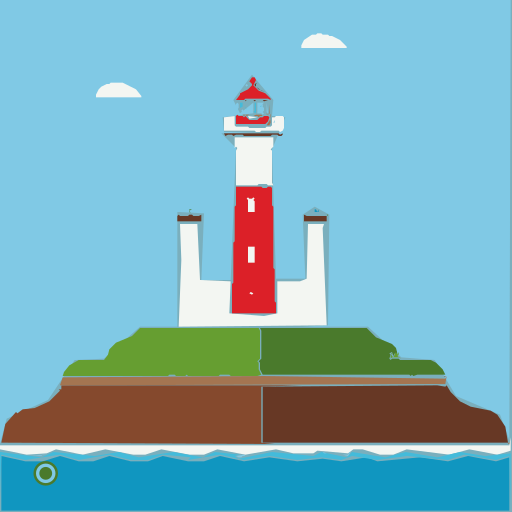

In [40]:
%%time
svg = model.predict(description)
SVG(svg)

In [41]:
metric.score_instance(r.multiple_choice_qa, svg, random_seed=42)

{'competition_score': 0.827968792885176,
 'vqa_score': 0.9980438245036137,
 'ocr_score': 1.0,
 'aesthetic_score': 0.4923598289489746}

## Evaluate on train dataset

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

In [44]:
train_df.iloc[14]['description']

'a maroon dodecahedron interwoven with teal threads'

In [45]:
train_df.head()

,id,description,qa,question,choices,answer,multiple_choice_qa
0,02d892,a purple forest at dusk,"{'id': ['02d892', '02d892', '02d892', '02d892'...","[""What is the main setting of the image?"", ""Is...","[[""beach"", ""desert"", ""forest"", ""mountain""], [""...","[""forest"", ""yes"", ""dusk"", ""purple""]",{'question': ['What is the main setting of the...
1,0dcd2e,gray wool coat with a faux fur collar,"{'id': ['0dcd2e', '0dcd2e', '0dcd2e', '0dcd2e'...","[""What color is the coat?"", ""What part of the ...","[[""blue"", ""brown"", ""gray"", ""red""], [""collar"", ...","[""gray"", ""collar"", ""no"", ""wool""]","{'question': ['What color is the coat?', 'What..."
2,1e9ac1,a lighthouse overlooking the ocean,"{'id': ['1e9ac1', '1e9ac1', '1e9ac1', '1e9ac1'...","[""Is there an ocean visible in the image?"", ""W...","[[""no"", ""yes""], [""inside"", ""next to"", ""overloo...","[""yes"", ""overlooking"", ""no"", ""no""]",{'question': ['Is there an ocean visible in th...
3,2b25db,burgundy corduroy pants with patch pockets and...,"{'id': ['2b25db', '2b25db', '2b25db', '2b25db'...","[""Are the pants yellow?"", ""Do the pants have p...","[[""no"", ""yes""], [""no"", ""yes""], [""no"", ""yes""], ...","[""no"", ""yes"", ""yes"", ""pants""]","{'question': ['Are the pants yellow?', 'Do the..."
4,4e6a54,orange corduroy overalls,"{'id': ['4e6a54', '4e6a54', '4e6a54', '4e6a54'...","[""What material is the item?"", ""Is a hat depic...","[[""corduroy"", ""denim"", ""leather"", ""silk""], [""n...","[""corduroy"", ""no"", ""yes"", ""overalls""]","{'question': ['What material is the item?', 'I..."


In [46]:
%%time
train_df['raw_res'] = train_df.description.progress_apply(model.predict_impl)

  0%|          | 0/15 [00:00<?, ?it/s]

Initializing LPIPS model on CPU...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Initializing LPIPS model on CPU...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Initializing LPIPS model on CPU...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Initializing LPIPS model on CPU...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Initializing LPIPS model on CPU...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Initializing LPIPS model on CPU...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Initializing LPIPS model on CPU...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Initializing LPIPS model on CPU...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Initializing LPIPS model on CPU...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Initializing LPIPS model on CPU...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Initializing LPIPS model on CPU...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Initializing LPIPS model on CPU...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Initializing LPIPS model on CPU...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Initializing LPIPS model on CPU...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/50 [00:00<?, ?it/s]

Initializing LPIPS model on CPU...
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 1h 12min 49s, sys: 5min 49s, total: 1h 18min 39s
Wall time: 40min 7s


In [47]:
train_df['svg'] = train_df.raw_res.apply(lambda x: x[0])
train_df['bitmap'] = train_df.raw_res.apply(lambda x: x[1])

In [48]:
train_df['bitmap_score'] = train_df.progress_apply(
    lambda r: bitmap_score_instance(r.multiple_choice_qa, r.bitmap, random_seed=42),
    axis=1,
)

  0%|          | 0/15 [00:00<?, ?it/s]

In [49]:
train_df['svg_score'] = train_df.progress_apply(
    lambda r: metric.score_instance(r.multiple_choice_qa, r.svg, random_seed=42),
    axis=1,
)

  0%|          | 0/15 [00:00<?, ?it/s]

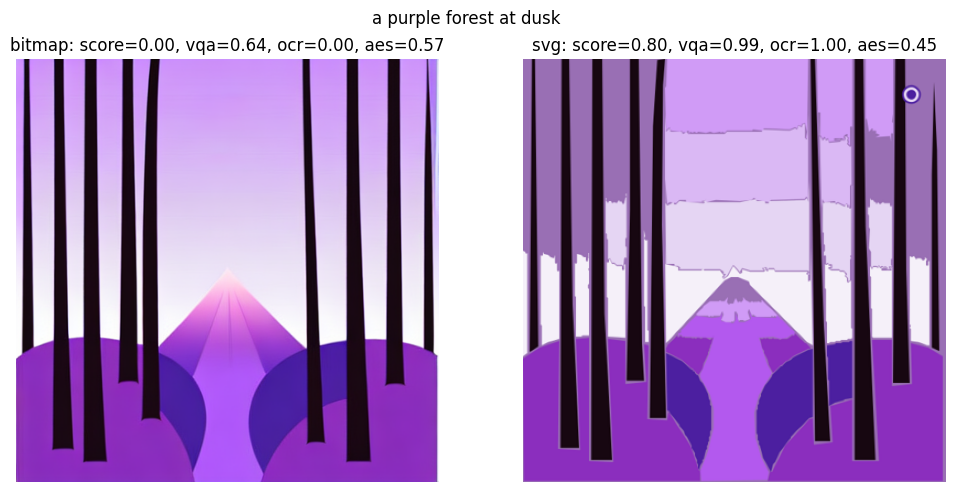

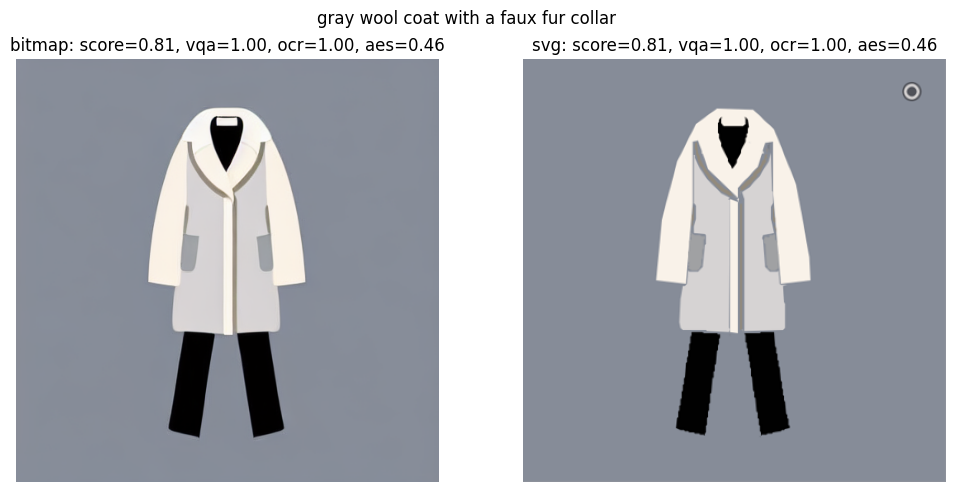

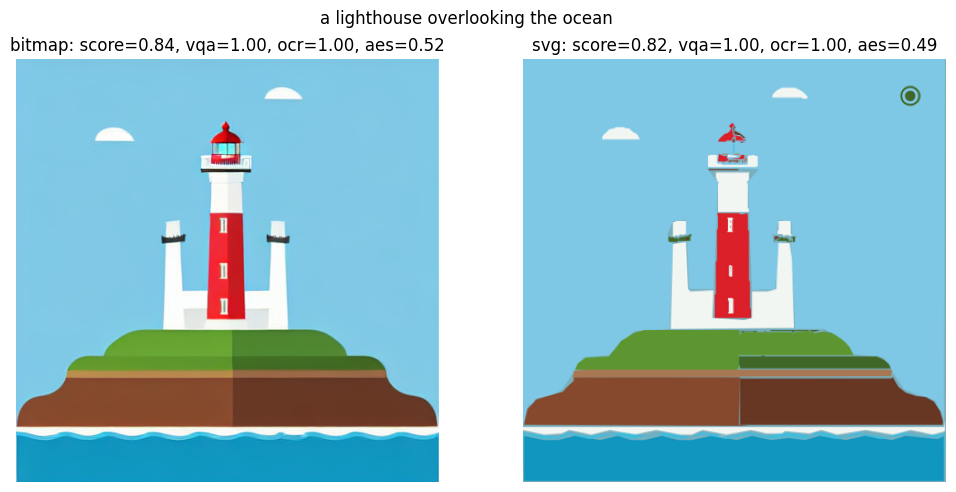

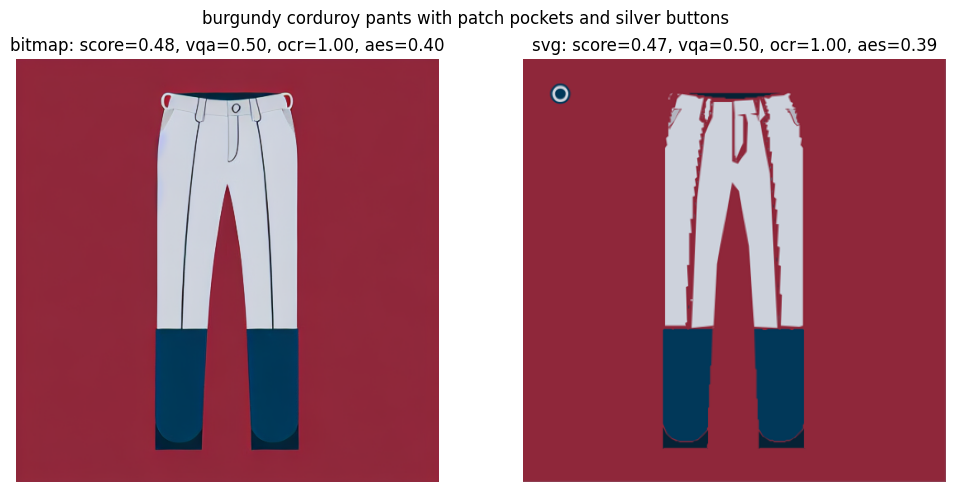

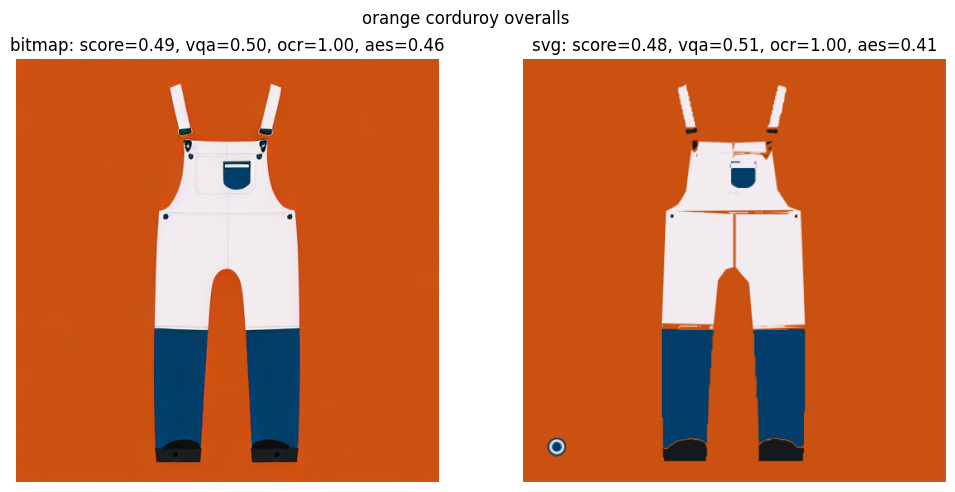

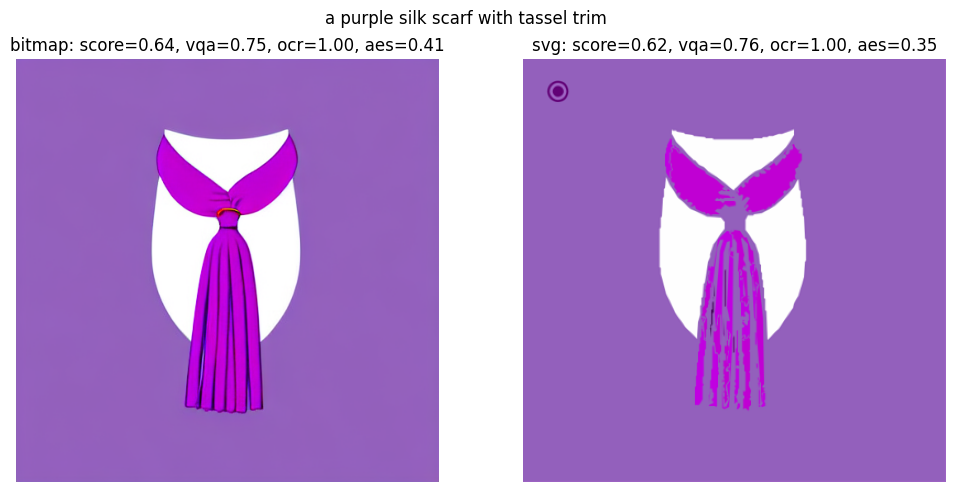

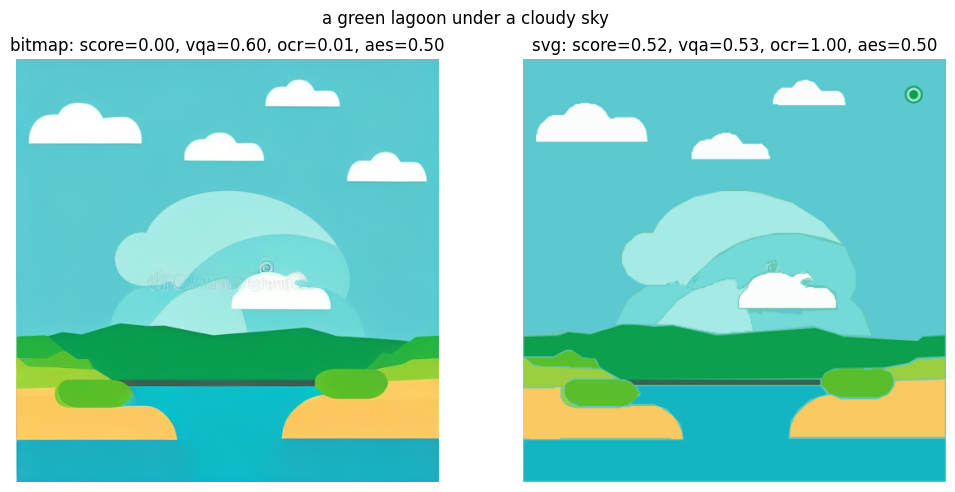

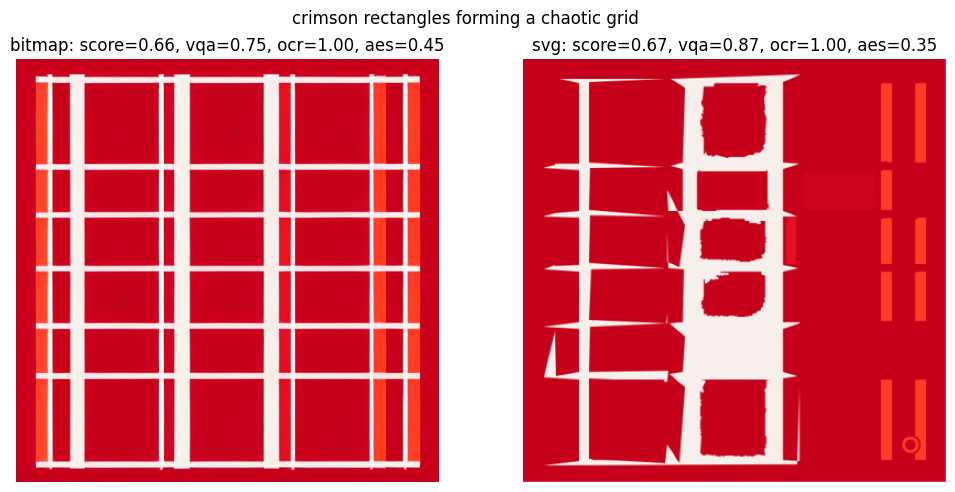

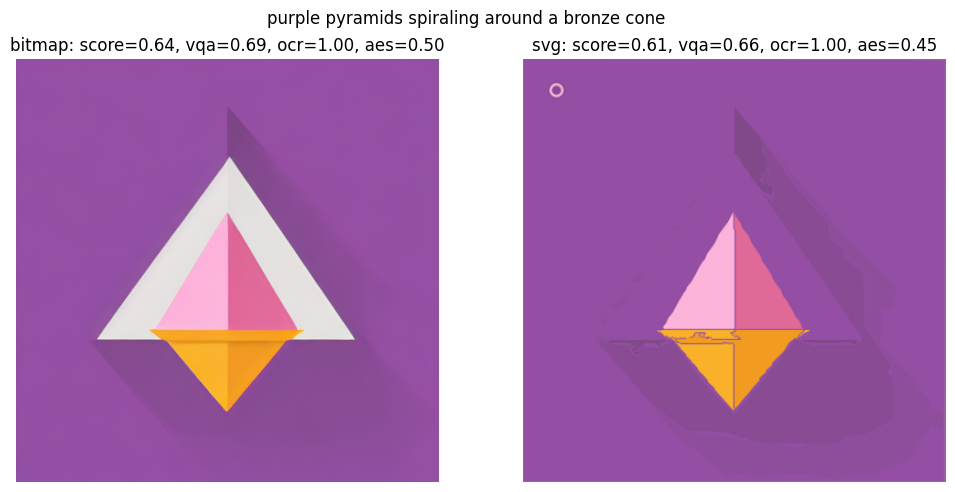

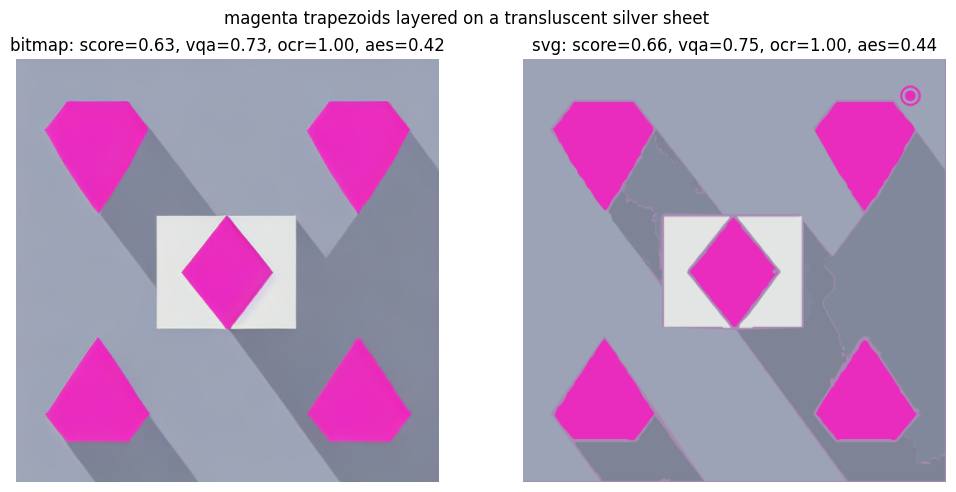

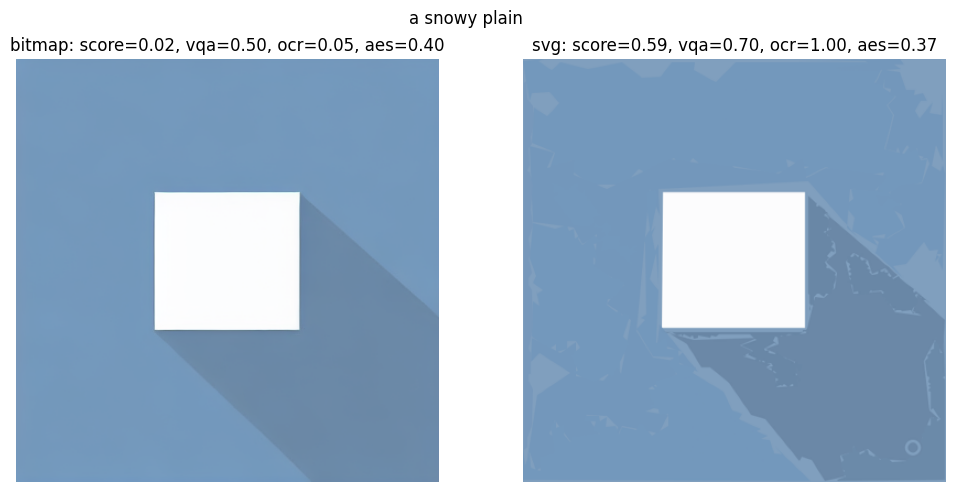

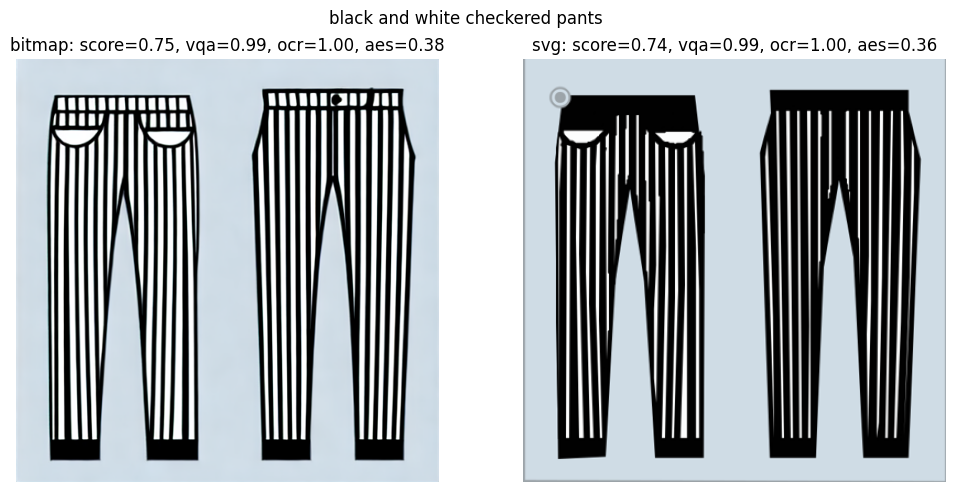

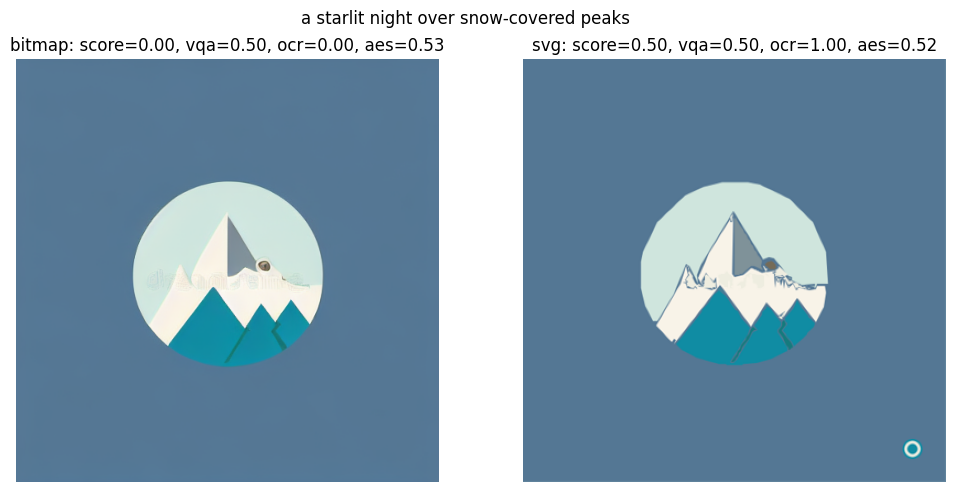

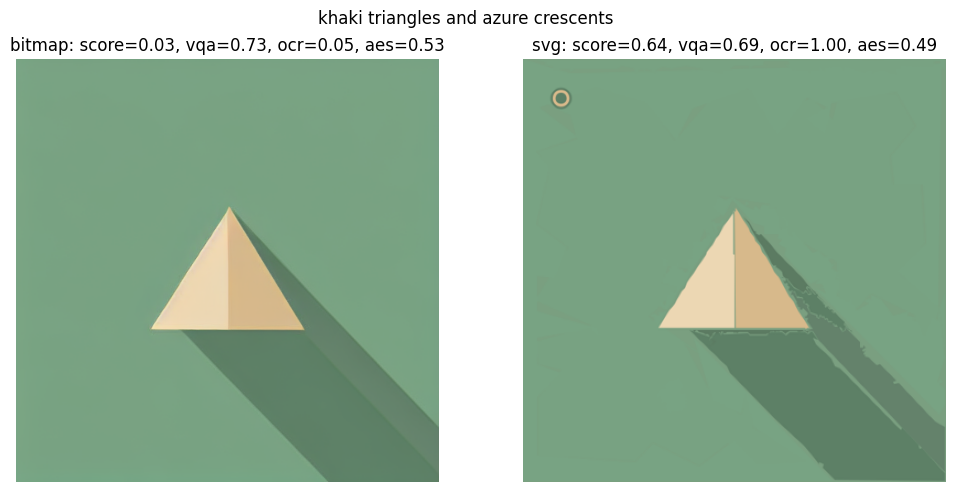

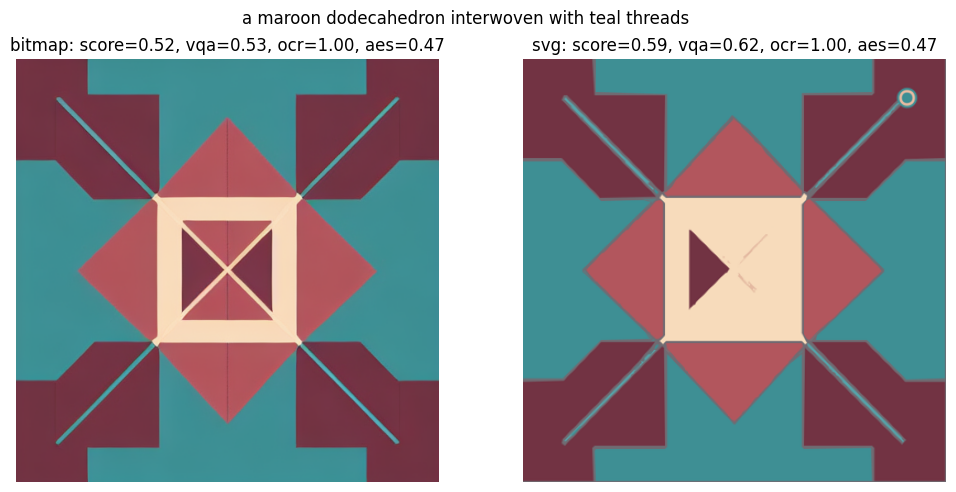

In [50]:
for r in train_df.itertuples():
    b_score = r.bitmap_score['competition_score']
    b_vqa = r.bitmap_score['vqa_score']
    b_ocr = r.bitmap_score['ocr_score']
    b_aesthetic = r.bitmap_score['aesthetic_score']

    s_score = r.svg_score['competition_score']
    s_vqa = r.svg_score['vqa_score']
    s_ocr = r.svg_score['ocr_score']
    s_aesthetic = r.svg_score['aesthetic_score']
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(r.description, y=0.93)
    
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(r.bitmap))
    plt.axis('off')
    plt.title(f'bitmap: score={b_score:.2f}, vqa={b_vqa:.2f}, ocr={b_ocr:.2f}, aes={b_aesthetic:.2f}')
    # plt.title(f'bitmap')

    plt.subplot(1, 2, 2)
    plt.imshow(metric.svg_to_png(r.svg))
    plt.axis('off')
    plt.title(f'svg: score={s_score:.2f}, vqa={s_vqa:.2f}, ocr={s_ocr:.2f}, aes={s_aesthetic:.2f}')
    # plt.title(f'svg')

In [51]:
mean_bitmap_score = pd.DataFrame(train_df['bitmap_score'].tolist()).mean(axis=0)
mean_bitmap_score

competition_score    0.435249
vqa_score            0.693891
ocr_score            0.673921
aesthetic_score      0.465886
dtype: float64

In [52]:
mean_svg_score = pd.DataFrame(train_df['svg_score'].tolist()).mean(axis=0)
mean_svg_score

competition_score    0.635118
vqa_score            0.738415
ocr_score            1.000000
aesthetic_score      0.433607
dtype: float64

In [53]:
print(f'Original bitmap score: {mean_bitmap_score.competition_score}')
print(f'Final svg score: {mean_svg_score.competition_score}')

Original bitmap score: 0.4352487514492199
Final svg score: 0.635118051921653
